# Joint single-cell mitochondrial DNA genotyping and DNA accessibility analysis
### Jonathan Levine


Here, we take a look at smack analzying variants from the mtscATAC  dataset from https://www.nature.com/articles/s41587-020-0645-6#Fig3

In [1]:
import numpy as np
import pandas as pd
import os
import sys
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib_venn import venn2, venn3

#### Load Data
The regular data is filtered using 2 different strategies: 
###### 1. The 6hr data and the 1hr data are filtered separately and then combined after variant calling and filtering 
###### 2.  The two datasets are combined and variants are filtered in a joint matrix with joint statistics

There is also a version of the "combined" dataset that uses MEAN_QUALITY based consensus calling instead of regular consensus calling

In [10]:
hr6_dir = "tf1_mtscatac_separate_TF1-MERFF_hr6/final"
hr1_dir = "tf1_mtscatac_separate_TF1-MERFF_hr1/final"
combined_dir = "tf1_combined_mtscatac_all/final"
quality_dir = "tf1_combined_mtscatac_all_quality_based/final"


In [11]:
hr1_df = pd.read_csv(os.path.join(hr1_dir,'final_variants_statistics.csv'),index_col='variant')
hr6_df = pd.read_csv(os.path.join(hr6_dir,'final_variants_statistics.csv'),index_col='variant')
combined_df = pd.read_csv(os.path.join(combined_dir,'final_variants_statistics.csv'),index_col='variant')
quality_df = pd.read_csv(os.path.join(quality_dir,'final_variants_statistics.csv'),index_col='variant')


Text(0.5, 1.0, 'TF1 & TF6 Unique Variants')

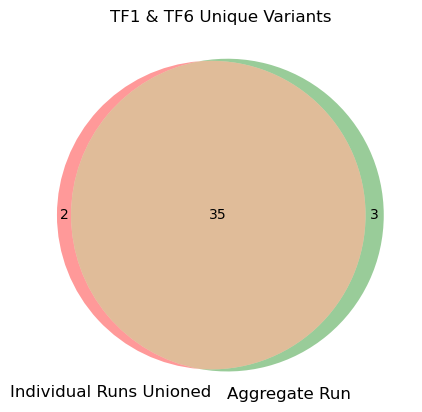

In [4]:
# First Compare Combined vs Separate Strategy
unioned_variants = set(hr6_df.index).union(set(hr1_df.index))
combined_variants = set(combined_df.index)
venn2([unioned_variants, combined_variants], ['Individual Runs Unioned', 'Aggregate Run'])
plt.title('TF1 & TF6 Unique Variants')

Text(0, 0.5, 'n cells over 5')

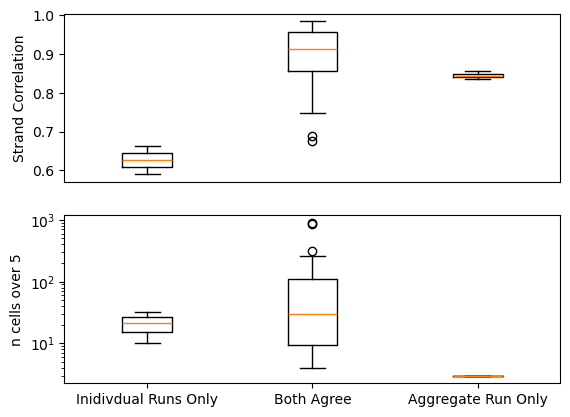

In [7]:
all_variants_combined_stats = pd.read_csv(
    os.path.join(combined_dir,'all_variants_statistics.csv'),index_col='variant')

left = unioned_variants.difference(combined_variants)
center = unioned_variants.intersection(combined_variants)
right = combined_variants.difference(unioned_variants)
left_df = all_variants_combined_stats.loc[list(left)]
center_df = combined_df.loc[list(center)]
right_df = combined_df.loc[list(right)]

plt.figure()
plt.subplot(2,1,1)

l_c_r = [left_df, center_df, right_df]
labels = ['Inidivdual Runs Only', 'Both Agree', 'Aggregate Run Only']
plt.ylabel('Strand Correlation')
plt.boxplot([df['strand_correlation'] for df in l_c_r])
plt.xticks([])

plt.subplot(2,1,2)
plt.boxplot([df['n_cells_over_5'] for df in l_c_r], labels=labels)
plt.yscale('log')
plt.ylabel('n cells over 5')


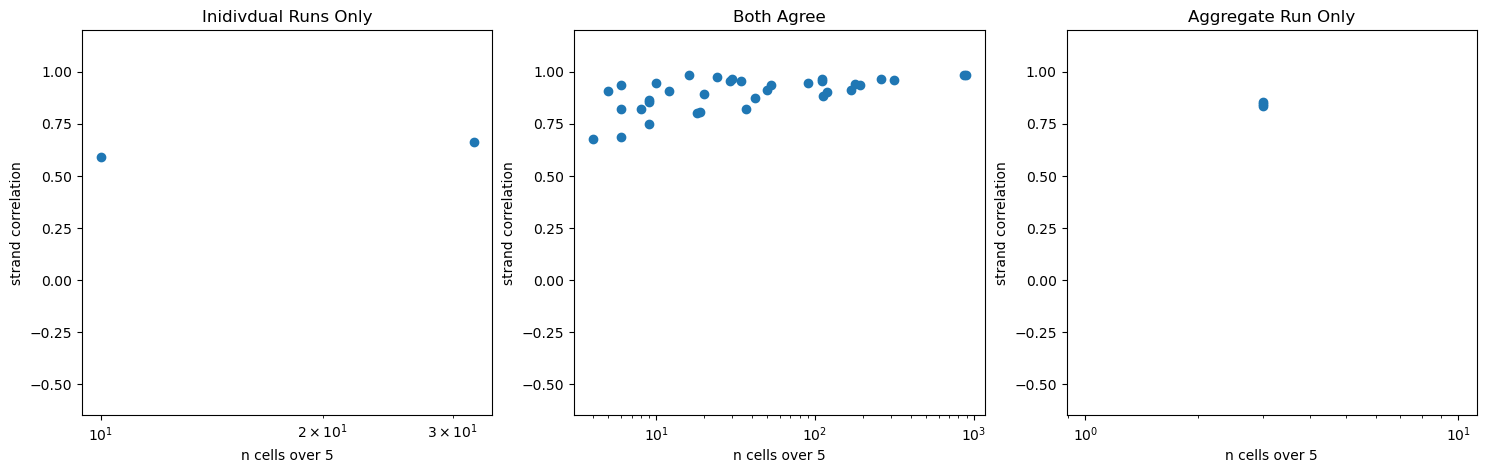

In [8]:
plt.figure(figsize=(18,5))
for i,df in enumerate(l_c_r):
    plt.subplot(1,3,i+1)
    plt.title(labels[i])
    plt.scatter(df['n_cells_over_5'],df['strand_correlation'])
    plt.xscale('log')
    plt.xlabel('n cells over 5')
    plt.ylabel('strand correlation')
    plt.ylim([-.65, 1.2])

In [9]:
for i,df in enumerate(l_c_r):
    print(labels[i])
    print(list(df[df['n_cells_over_5']>10**2].index))
    print("----")

Inidivdual Runs Only
[]
----
Both Agree
['13708_G_A', '8002_C_T', '10068_G_A', '7316_G_A', '3901_G_A', '7789_G_C', '10552_C_T', '1888_G_A', '5790_C_T', '627_G_A', '4037_G_A']
----
Aggregate Run Only
[]
----


Text(0.5, 1.0, 'TF1 & TF6 Unique Variants')

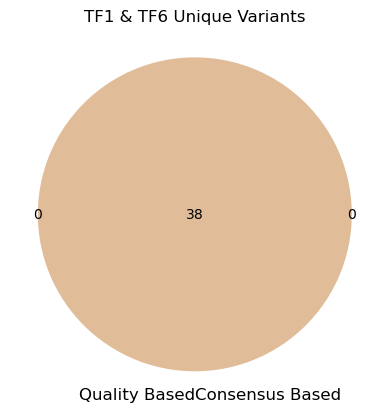

In [13]:
# Compare Quality based filtering variants
quality_variants = set(quality_df.index)
combined_variants = set(combined_df.index)
venn2([quality_variants, combined_variants], ['Quality Based', 'Consensus Based'])
plt.title('TF1 & TF6 Unique Variants')

In [16]:
heteroplasmy_matrix = pd.read_csv(os.path.join(combined_dir,'final_variants_heteroplasmy_matrix.csv'),index_col='variant')


In [17]:
heteroplasmy_matrix.head(5)

,TF1-MERFF_hr1_TTCGTTATCCCGTAGG-1,TF1-MERFF_hr1_AACCGATTCAAGAGAT-1,TF1-MERFF_hr6_CAGCTAACAGAACAGC-1,TF1-MERFF_hr6_GTAATCGAGAACGACC-1,TF1-MERFF_hr1_ACTAGGTTCCTTCGAC-1,TF1-MERFF_hr6_TGCTTTATCAAGGCAG-1,TF1-MERFF_hr6_TTCTGTACATTACTCT-1,TF1-MERFF_hr1_ACTTCCGTCACCCGGA-1,TF1-MERFF_hr6_CGTACAACACCGTCTT-1,TF1-MERFF_hr6_ACCTGCTAGCTTACCA-1,...,TF1-MERFF_hr1_AACCGATCATAGCCAT-1,TF1-MERFF_hr6_CTTGTCGTCGCTCGGA-1,TF1-MERFF_hr6_AACCAACTCGAAGCCC-1,TF1-MERFF_hr6_TACCTCGCACCGTCTT-1,TF1-MERFF_hr6_AGTCAACTCCGAATTG-1,TF1-MERFF_hr1_GAGCATTCAGCGTGAA-1,TF1-MERFF_hr1_TTACCCGTCCATAGGT-1,TF1-MERFF_hr6_CAACCAAAGGATTAAC-1,TF1-MERFF_hr6_CCCGTTATCATGCTTT-1,TF1-MERFF_hr6_TCCCACAAGGTGTCGA-1
variant,,,,,,,,,,,,,,,,,,,,,
2002_G_A,0.0,0.00000,0.0,0.000000,0.00000,0.000000,0.0,0.0,0.005848,0.0,...,0.000000,0.0,0.0,0.0,0.019481,0.0,0.000000,0.000000,0.0,0.0
2573_G_A,0.0,0.00000,0.0,0.000000,0.00000,0.000000,0.0,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0
12012_C_T,0.0,0.00000,0.0,0.000000,0.00000,0.000000,0.0,0.0,0.050000,0.0,...,0.000000,0.0,0.0,0.0,0.043796,0.0,0.000000,0.000000,0.0,0.0
3901_G_A,0.0,0.18123,0.0,0.065341,0.16763,0.105263,0.0,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.195055,0.148649,0.0,0.0
15646_C_T,0.0,0.00000,0.0,0.000000,0.00000,0.000000,0.0,0.0,0.000000,0.0,...,0.029412,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0


Text(0.5, 0.98, 'Combined TF1 & TF6 Variants')

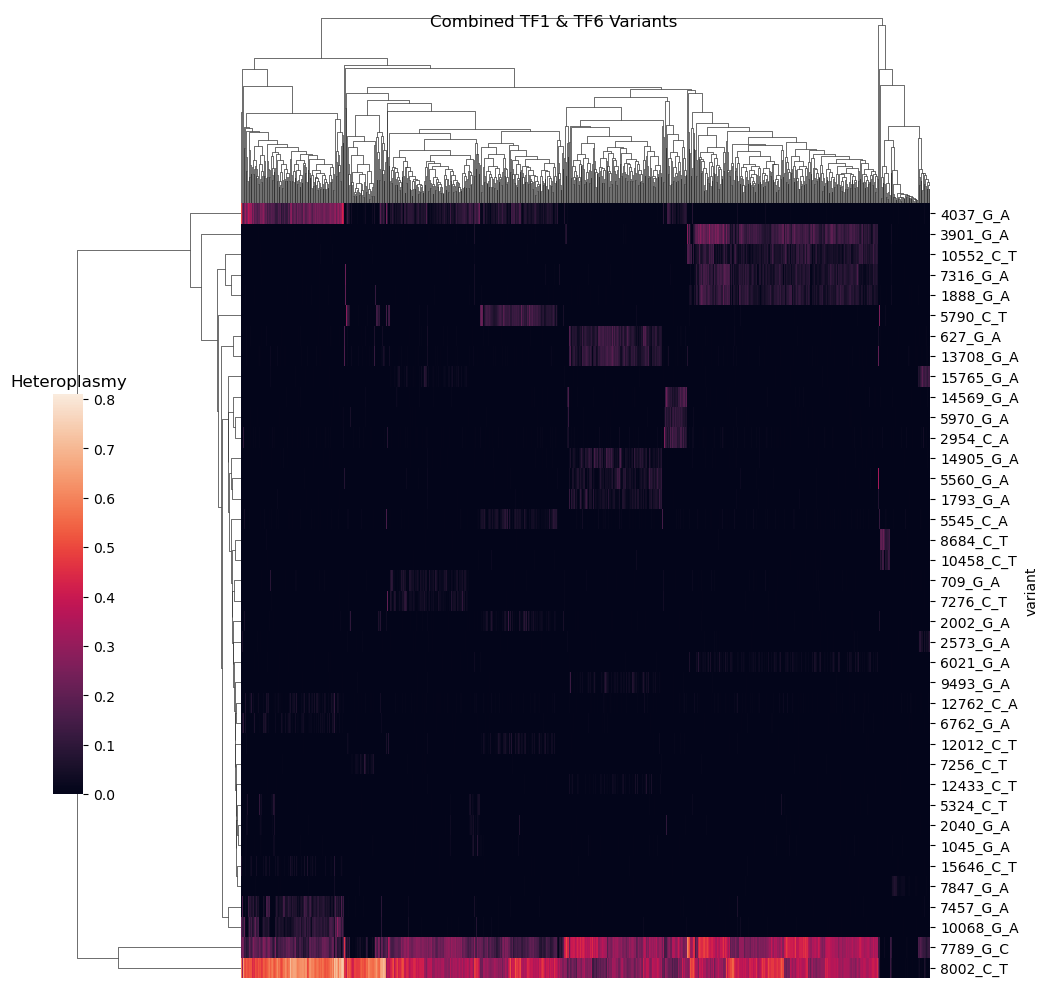

In [18]:
sns.clustermap(heteroplasmy_matrix,xticklabels=False,cbar_pos=(0, .2, .03, .4),dendrogram_ratio=.2,yticklabels=True)
plt.title('Heteroplasmy')
plt.suptitle('Combined TF1 & TF6 Variants')

Text(0.5, 0.98, 'Combined TF1 & TF6 Variants')

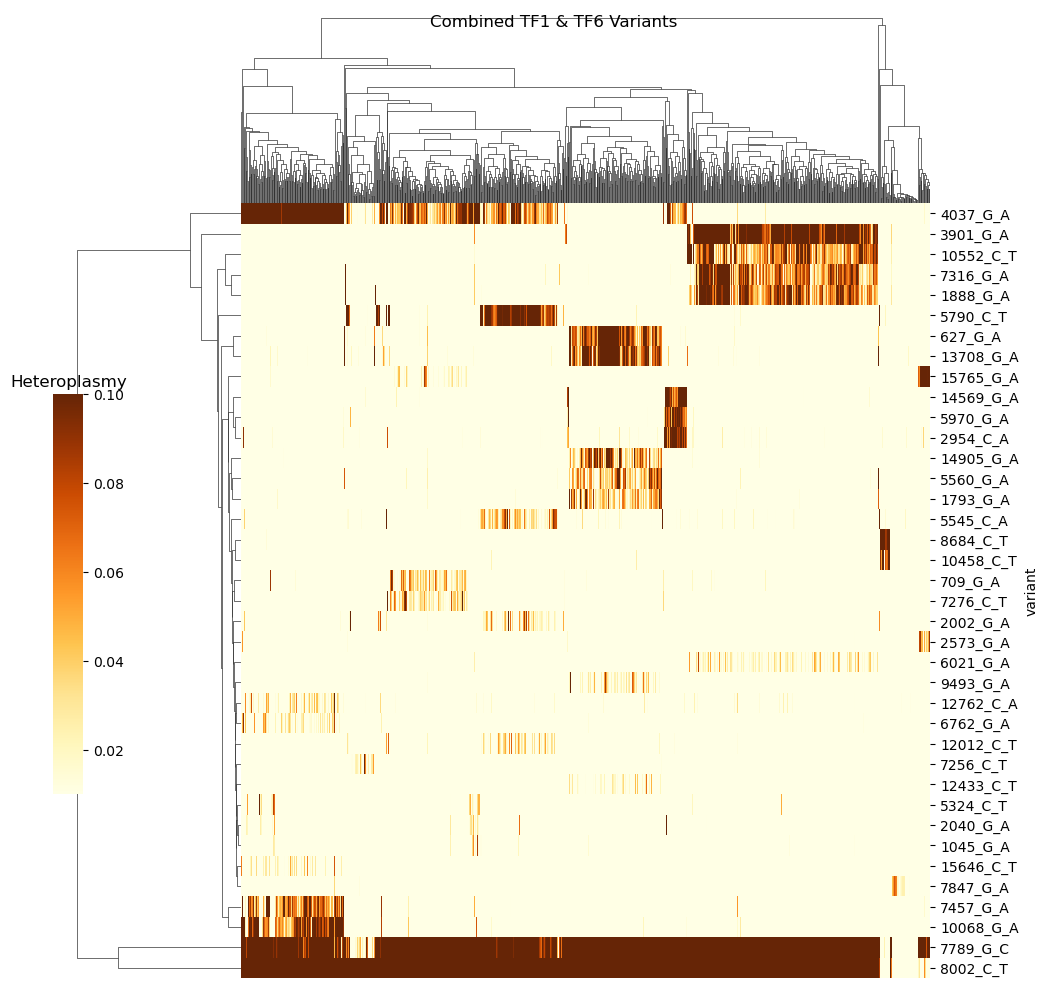

In [19]:
sns.clustermap(heteroplasmy_matrix,xticklabels=False,cbar_pos=(0, .2, .03, .4),dendrogram_ratio=.2,yticklabels=True,
               vmin=.01, vmax=.1,cmap=sns.color_palette("YlOrBr", as_cmap=True))
plt.title('Heteroplasmy')
plt.suptitle('Combined TF1 & TF6 Variants')

In [20]:
quality_heteroplasmy_matrix = pd.read_csv(os.path.join(quality_dir,'final_variants_heteroplasmy_matrix.csv'),index_col='variant')


Text(0.5, 0.98, 'Combined TF1 & TF6 Variants')

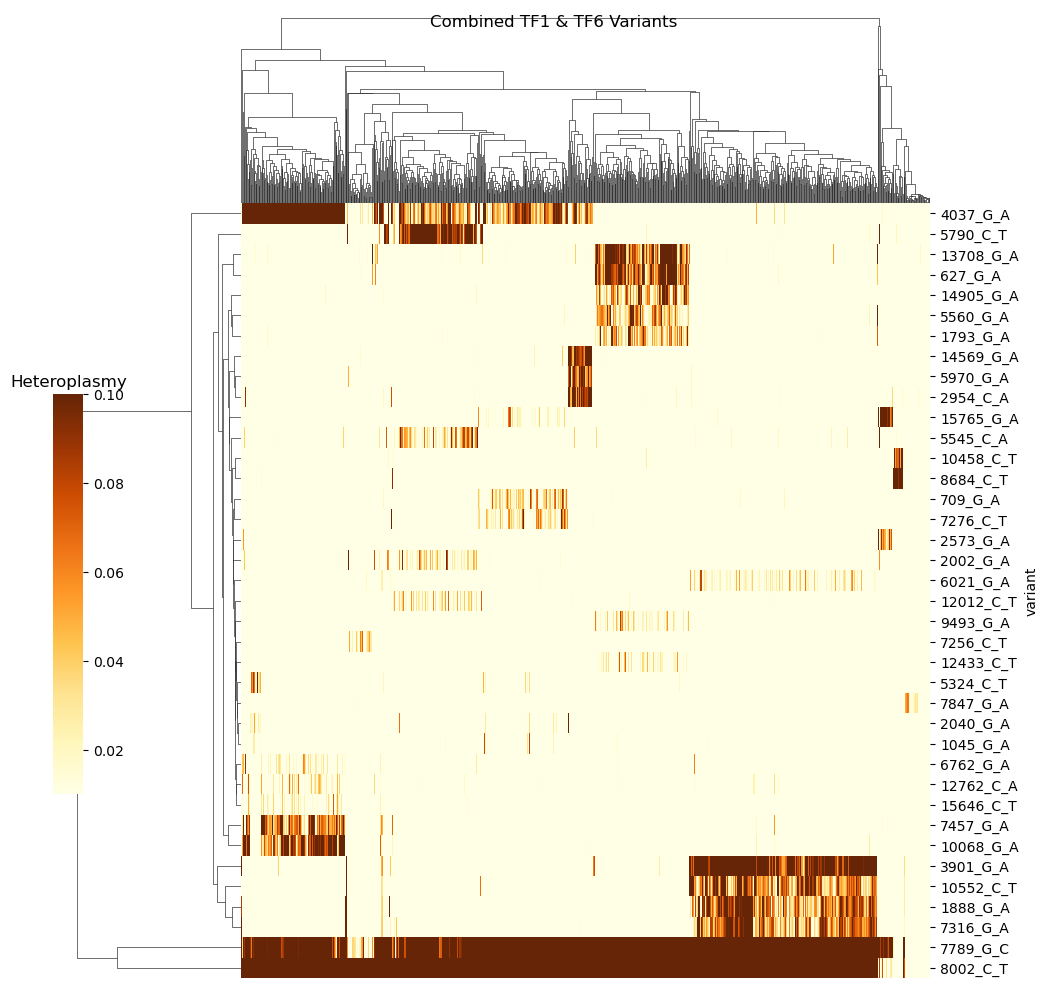

In [21]:
sns.clustermap(quality_heteroplasmy_matrix,xticklabels=False,cbar_pos=(0, .2, .03, .4),dendrogram_ratio=.2,yticklabels=True,
               vmin=.01, vmax=.1,cmap=sns.color_palette("YlOrBr", as_cmap=True))
plt.title('Heteroplasmy')
plt.suptitle('Combined TF1 & TF6 Variants')

<Axes: ylabel='Proportion'>

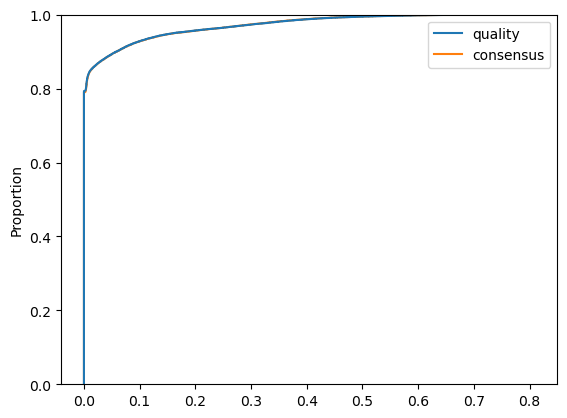

In [44]:
# ECDF Plots
fig, ax = plt.subplots()
quality_values = quality_heteroplasmy_matrix.values.flatten()
het_values = heteroplasmy_matrix.values.flatten()
df = pd.DataFrame()
df['quality'] = quality_values
df['consensus'] = het_values
sns.ecdfplot(data=df)


<Axes: ylabel='Proportion'>

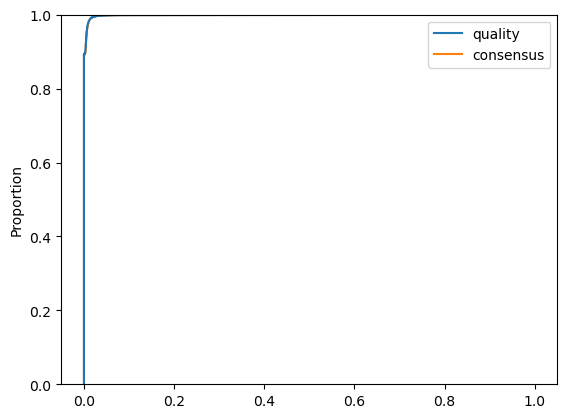

In [45]:
fig, ax = plt.subplots()
quality_values = pd.read_csv(os.path.join(quality_dir,'all_variants_heteroplasmy_matrix.csv'),index_col='variant').values.flatten()
het_values = pd.read_csv(os.path.join(combined_dir,'all_variants_heteroplasmy_matrix.csv'),index_col='variant').values.flatten()
df = pd.DataFrame()
df['quality'] = quality_values
df['consensus'] = het_values
sns.ecdfplot(data=df)


Text(0.5, 1.0, 'C - Q')

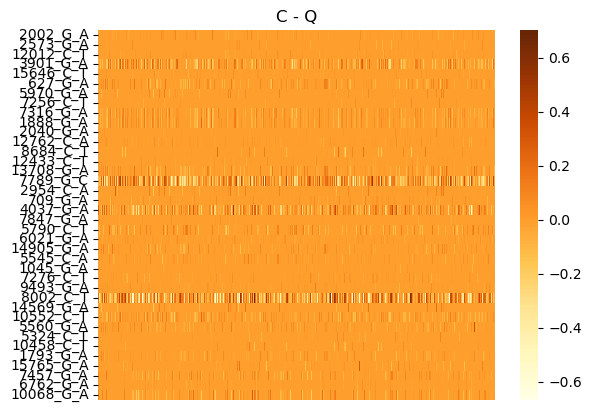

In [48]:

difference  = heteroplasmy_matrix.values - quality_heteroplasmy_matrix.loc[heteroplasmy_matrix.index].values
sns.heatmap(difference,cmap=sns.color_palette("YlOrBr", as_cmap=True),yticklabels=heteroplasmy_matrix.index,xticklabels=False)
plt.title('C - Q')

In [58]:
100*(sum(heteroplasmy_matrix.values.flatten() > 0) / len(heteroplasmy_matrix.values.flatten()))

20.99774984907524

In [57]:
100*(sum(quality_heteroplasmy_matrix.values.flatten() > 0) / len(heteroplasmy_matrix.values.flatten()))

20.66022721036167

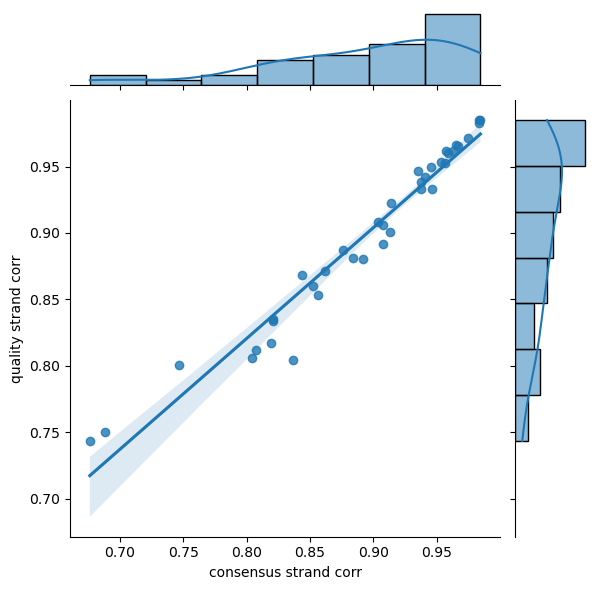

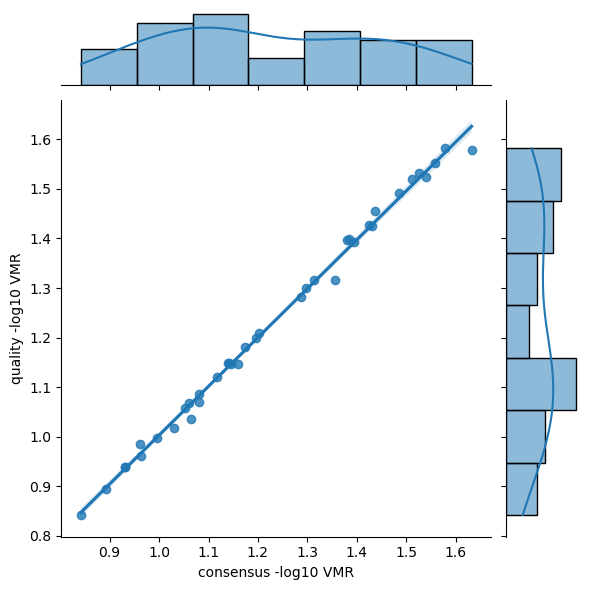

In [67]:
strand_con = combined_df['strand_correlation']
strand_qual  = quality_df['strand_correlation']
df = pd.DataFrame()
df.index = combined_df.index
df['consensus strand corr'] = strand_con
df['quality strand corr'] = strand_qual.loc[combined_df.index]
sns.jointplot(df, x='consensus strand corr',y='quality strand corr',kind='reg')

vmr_con = combined_df['vmr'].apply(lambda x: -1*np.log10(x))
vmr_qual  = quality_df['vmr'].apply(lambda x: -1*np.log10(x))
df = pd.DataFrame()
df.index = combined_df.index
df['consensus -log10 VMR'] = vmr_con
df['quality -log10 VMR'] = vmr_qual.loc[combined_df.index]
sns.jointplot(df, x='consensus -log10 VMR',y='quality -log10 VMR',kind='reg')

In [68]:
mgatk_variants = pd.read_csv('TF1_VMR_processed_variants_ndetect.tsv',header=None)

In [69]:
def map_variant(v):
    split_idx = v.index(">")
    return f"{v[:split_idx-1]}_{v[split_idx-1]}_{v[split_idx+1:]}"
mgatk_variants['variant'] = mgatk_variants[mgatk_variants.columns[0]].apply(map_variant)
mgatk_variants.head(5)

,0,variant
0,8002C>T,8002_C_T
1,7789G>C,7789_G_C
2,8684C>T,8684_C_T
3,15765G>A,15765_G_A
4,5970G>A,5970_G_A


In [70]:
mgatk_variants_set = set(mgatk_variants['variant'])

Text(0.5, 1.0, 'TF1 & TF6 Unique Variants')

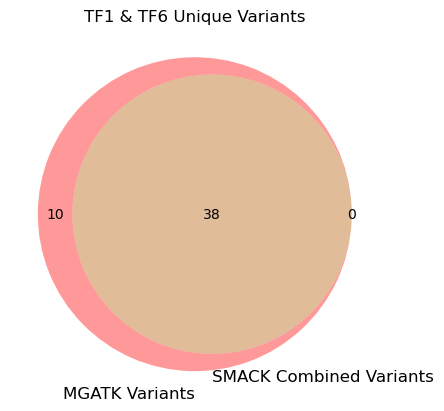

In [71]:
venn2([mgatk_variants_set, combined_variants], ['MGATK Variants', 'SMACK Combined Variants'])
plt.title('TF1 & TF6 Unique Variants')

In [72]:
left = mgatk_variants_set.difference(combined_variants)
center = mgatk_variants_set.intersection(combined_variants)
right = combined_variants.difference(mgatk_variants_set)

In [74]:
left_df = all_variants_combined_stats.loc[list(left)]
center_df = combined_df.loc[list(center)]
right_df = combined_df.loc[list(right)]

Text(0, 0.5, 'n cells over 5')

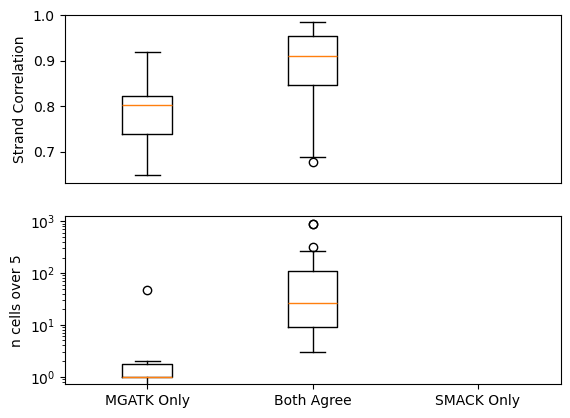

In [75]:
plt.figure()
plt.subplot(2,1,1)

l_c_r = [left_df, center_df, right_df]
labels = ['MGATK Only', 'Both Agree', 'SMACK Only']
plt.ylabel('Strand Correlation')
plt.boxplot([df['strand_correlation'] for df in l_c_r])
plt.xticks([])

plt.subplot(2,1,2)
plt.boxplot([df['n_cells_over_5'] for df in l_c_r], labels=labels)
plt.yscale('log')
plt.ylabel('n cells over 5')

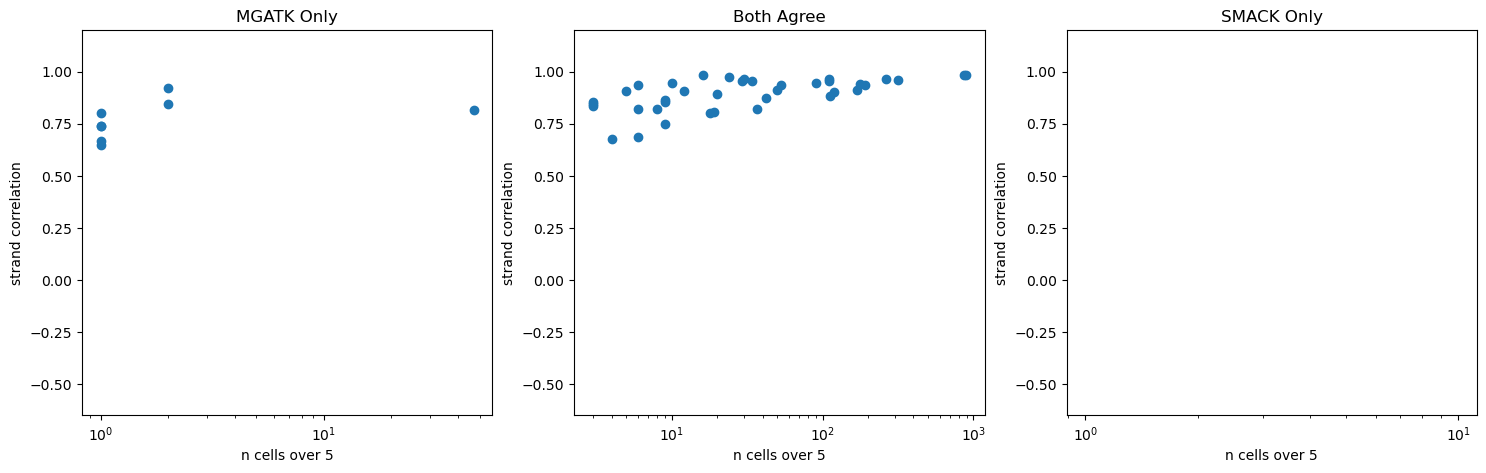

In [76]:
plt.figure(figsize=(18,5))
for i,df in enumerate(l_c_r):
    plt.subplot(1,3,i+1)
    plt.title(labels[i])
    plt.scatter(df['n_cells_over_5'],df['strand_correlation'])
    plt.xscale('log')
    plt.xlabel('n cells over 5')
    plt.ylabel('strand correlation')
    plt.ylim([-.65, 1.2])

In [78]:
all_variants_combined_stats.loc[list(left)]

,strand_correlation,variance,vmr,alt_ref_statistic,alt_uniform_statistic,ref_uniform_statistic,max_heteroplasmy,n_cells_over_5,n_cells_over_10,n_cells_over_20,...,n_cells_conf_detected,mean,mean_coverage,pass_mean_coverage,pass_strand_correlation,pass_vmr,pass_ncells,pass_position_bias,pass_homoplasmic,pass_filters
variant,,,,,,,,,,,,,,,,,,,,,
6713_C_T,0.740538,0.000026,0.021940,0.084858,0.144369,0.099012,0.071428,1,0,0,...,32,0.001171,181.895825,True,True,True,False,True,True,False
6027_G_A,0.919499,0.000021,0.026482,0.053289,0.103291,0.112553,0.064865,2,0,0,...,12,0.000790,199.139829,True,True,True,False,True,True,False
2789_C_T,0.805023,0.000009,0.022402,0.125366,0.207419,0.241368,0.044944,0,0,0,...,7,0.000417,170.449526,True,True,True,False,True,True,False
11196_G_A,0.823605,0.000011,0.018820,0.101015,0.120000,0.167804,0.043689,0,0,0,...,9,0.000601,188.565272,True,True,True,False,True,True,False
7521_G_A,0.800362,0.000021,0.023603,0.206684,0.190000,0.093191,0.060423,1,0,0,...,10,0.000874,170.355679,True,True,True,False,True,True,False
14559_C_T,0.648605,0.000032,0.022394,0.091394,0.123889,0.073421,0.062500,1,0,0,...,19,0.001435,152.576742,True,False,True,False,True,True,False
309_C_T,0.815215,0.021558,0.610553,0.116465,0.402661,0.332032,0.925922,47,39,35,...,21,0.035309,78.790507,True,True,True,True,False,True,False
7598_G_A,0.847354,0.000017,0.023664,0.250798,0.291887,0.041089,0.068493,2,0,0,...,10,0.000732,143.367149,True,True,True,False,True,True,False
2643_G_A,0.666863,0.000023,0.020075,0.059214,0.137778,0.085835,0.055276,1,0,0,...,15,0.001153,149.565272,True,True,True,False,True,True,False


In [82]:
full_matrix = pd.read_csv(os.path.join(combined_dir,'all_variants_heteroplasmy_matrix.csv'),index_col='variant')
full_matrix['variant'] = full_matrix.index
melted = full_matrix.loc[list(left)].melt(value_name='heteroplasmy',id_vars='variant')
melted.head(5)

,variant,variable,heteroplasmy
0,6713_C_T,TF1-MERFF_hr1_TTCGTTATCCCGTAGG-1,0.0
1,6027_G_A,TF1-MERFF_hr1_TTCGTTATCCCGTAGG-1,0.0
2,2789_C_T,TF1-MERFF_hr1_TTCGTTATCCCGTAGG-1,0.0
3,11196_G_A,TF1-MERFF_hr1_TTCGTTATCCCGTAGG-1,0.0
4,7521_G_A,TF1-MERFF_hr1_TTCGTTATCCCGTAGG-1,0.0


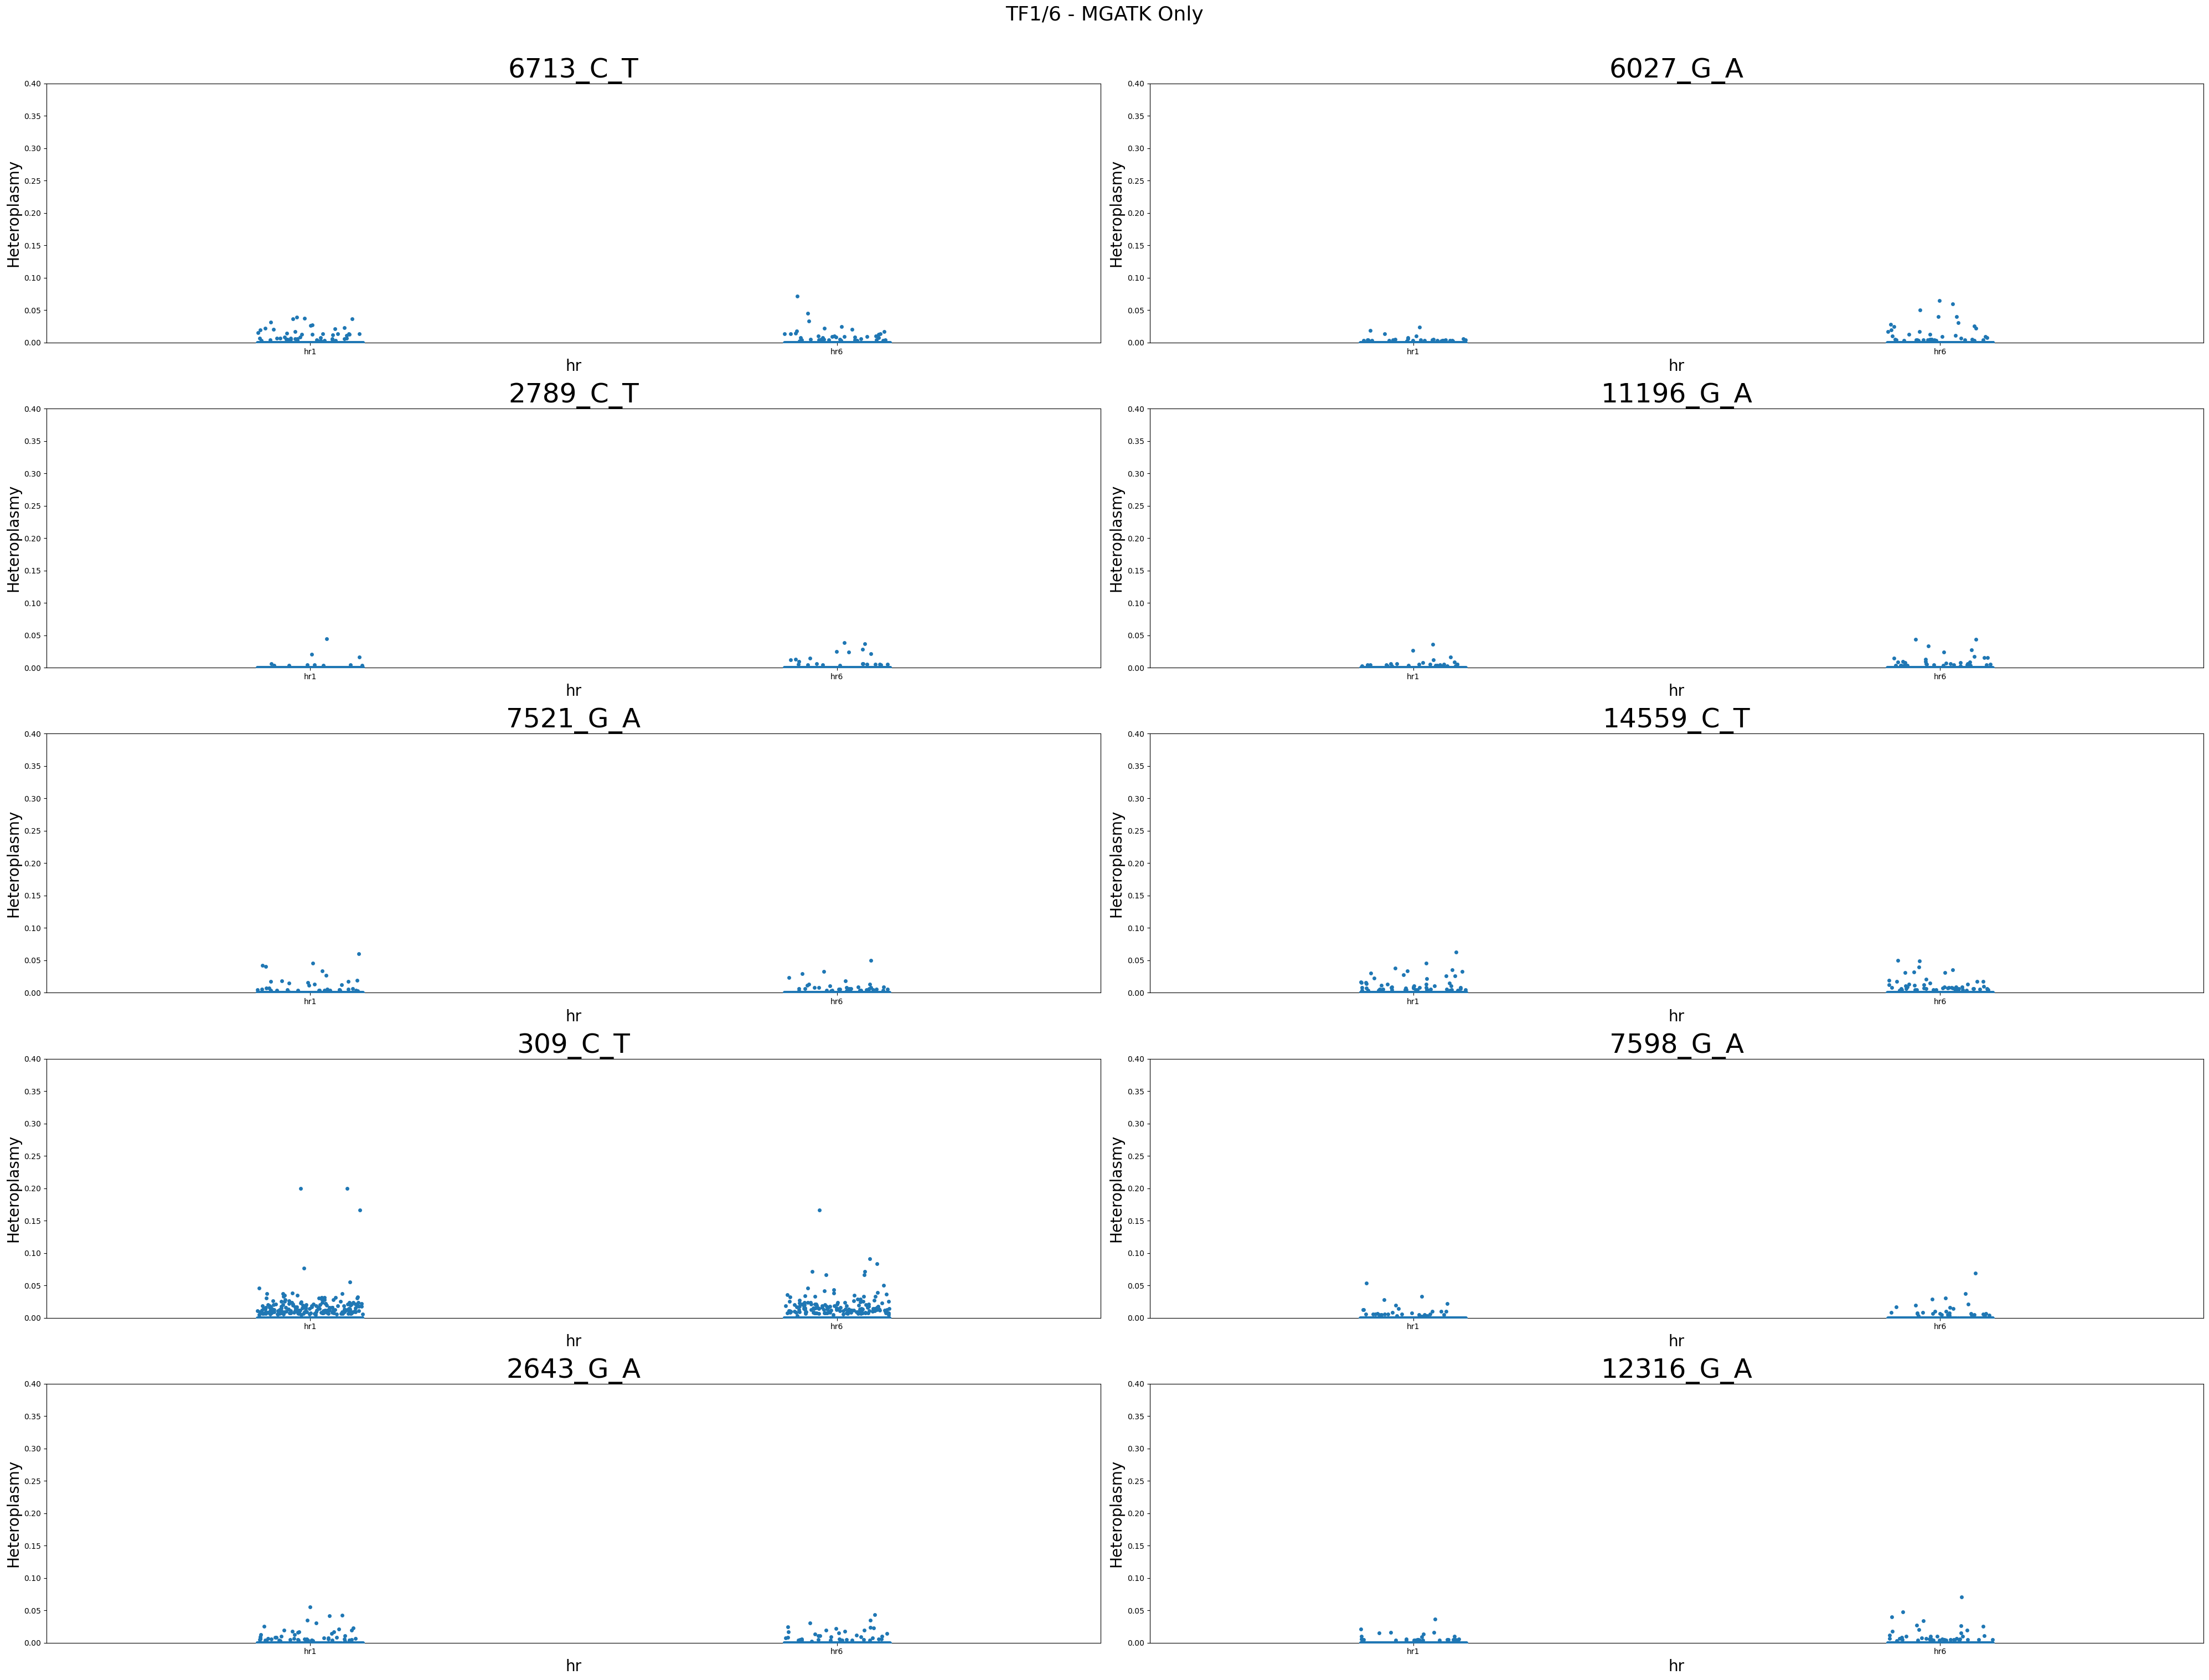

In [83]:
# MGATK only
melted['hr'] = melted['variable'].apply(lambda v: v.split("_")[1])

fig,ax = plt.subplots(5,2,figsize=(40,30))
for i,variant in enumerate(list(left)):
    
    variant_df = melted[melted['variant']==variant]
    _ax = ax.reshape(-1)[i]
    _ax.set_title(variant,fontsize=35)
    sns.stripplot(variant_df, x='hr',y='heteroplasmy',ax=_ax)
    _ax.set_xlabel('hr',fontsize=20)
    _ax.set_ylabel('Heteroplasmy',fontsize=20)
    _ax.set_ylim([0,.4])
#     _ax.set_xticklabels([])
    
fig.suptitle('TF1/6 - MGATK Only',fontsize=26,y=1.01)
fig.tight_layout()

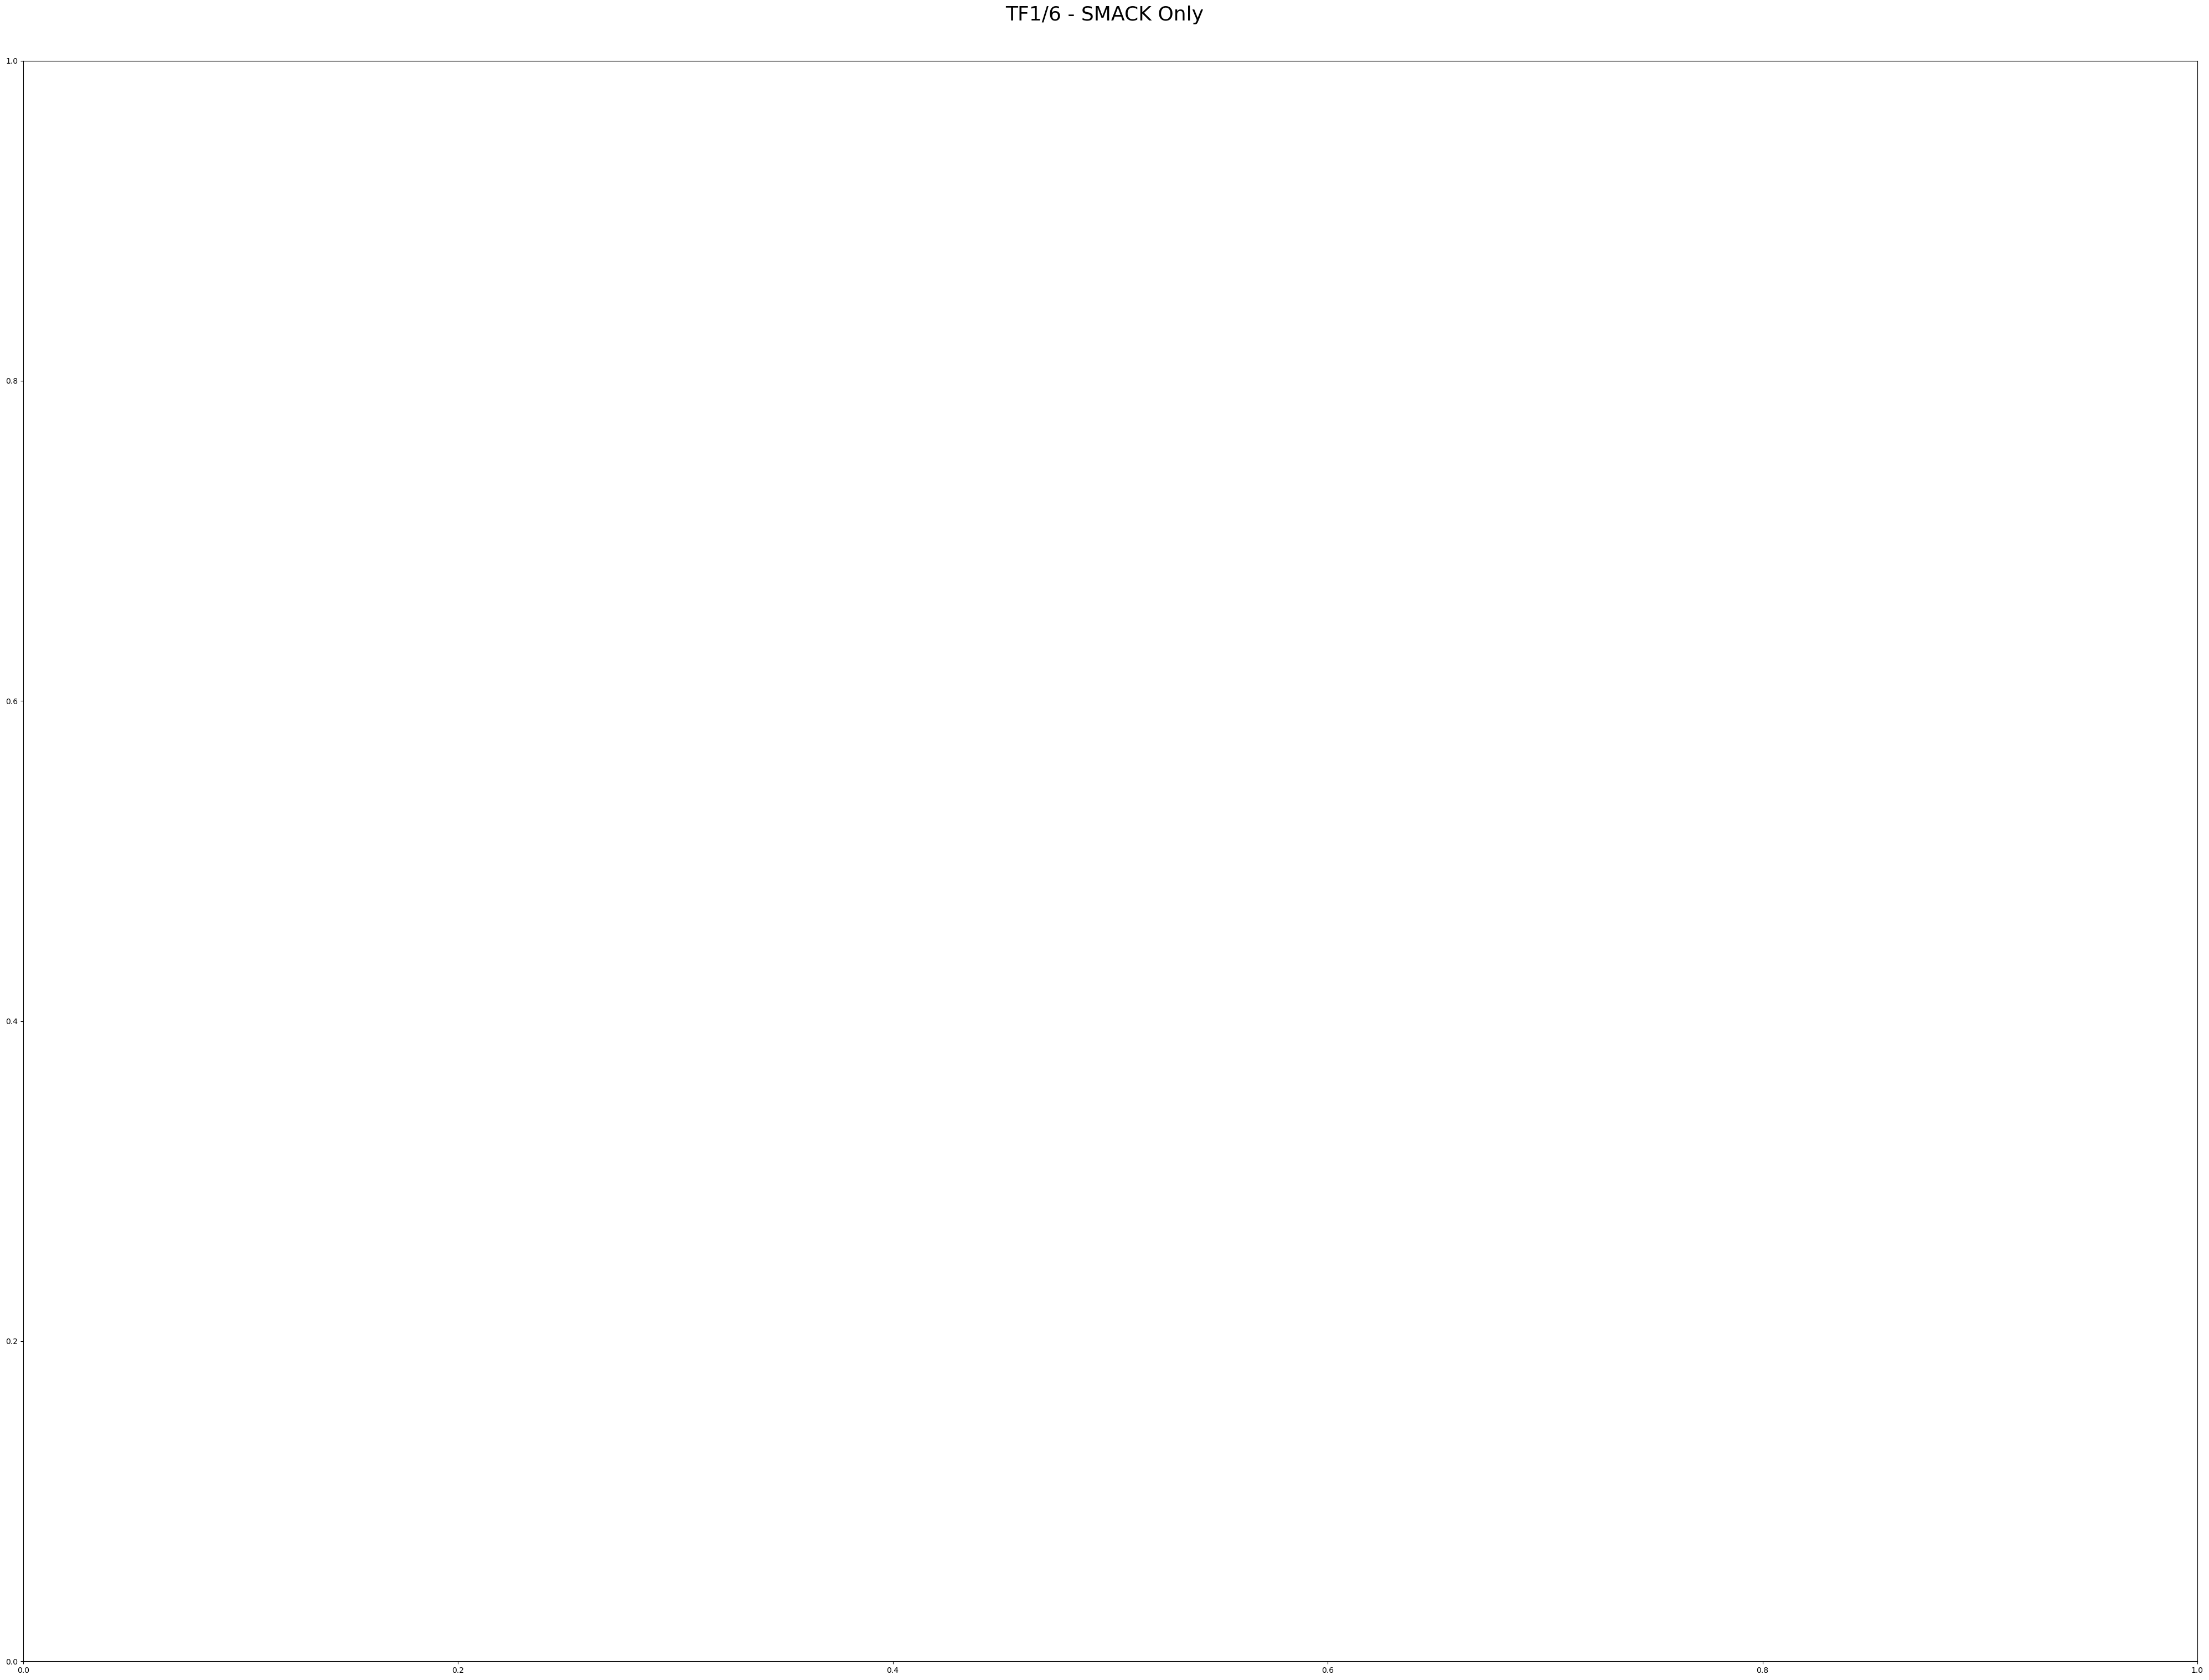

In [84]:
# SMACK only
melted = full_matrix.loc[list(right)].melt(value_name='heteroplasmy',id_vars='variant')
melted['hr'] = melted['variable'].apply(lambda v: v.split("_")[1])

fig,ax = plt.subplots(1,1,figsize=(40,30))
for i,variant in enumerate(list(right)):
    
    variant_df = melted[melted['variant']==variant]
    _ax = ax
    
    _ax.set_title(variant,fontsize=35)
    sns.stripplot(variant_df, x='hr',y='heteroplasmy',ax=_ax,size=30)
    _ax.set_xlabel('hr',fontsize=20)
    _ax.set_ylabel('Heteroplasmy',fontsize=20)
    _ax.set_ylim([0,.4])
#     _ax.set_xticklabels([])
    
fig.suptitle('TF1/6 - SMACK Only',fontsize=26,y=1.01)
fig.tight_layout()

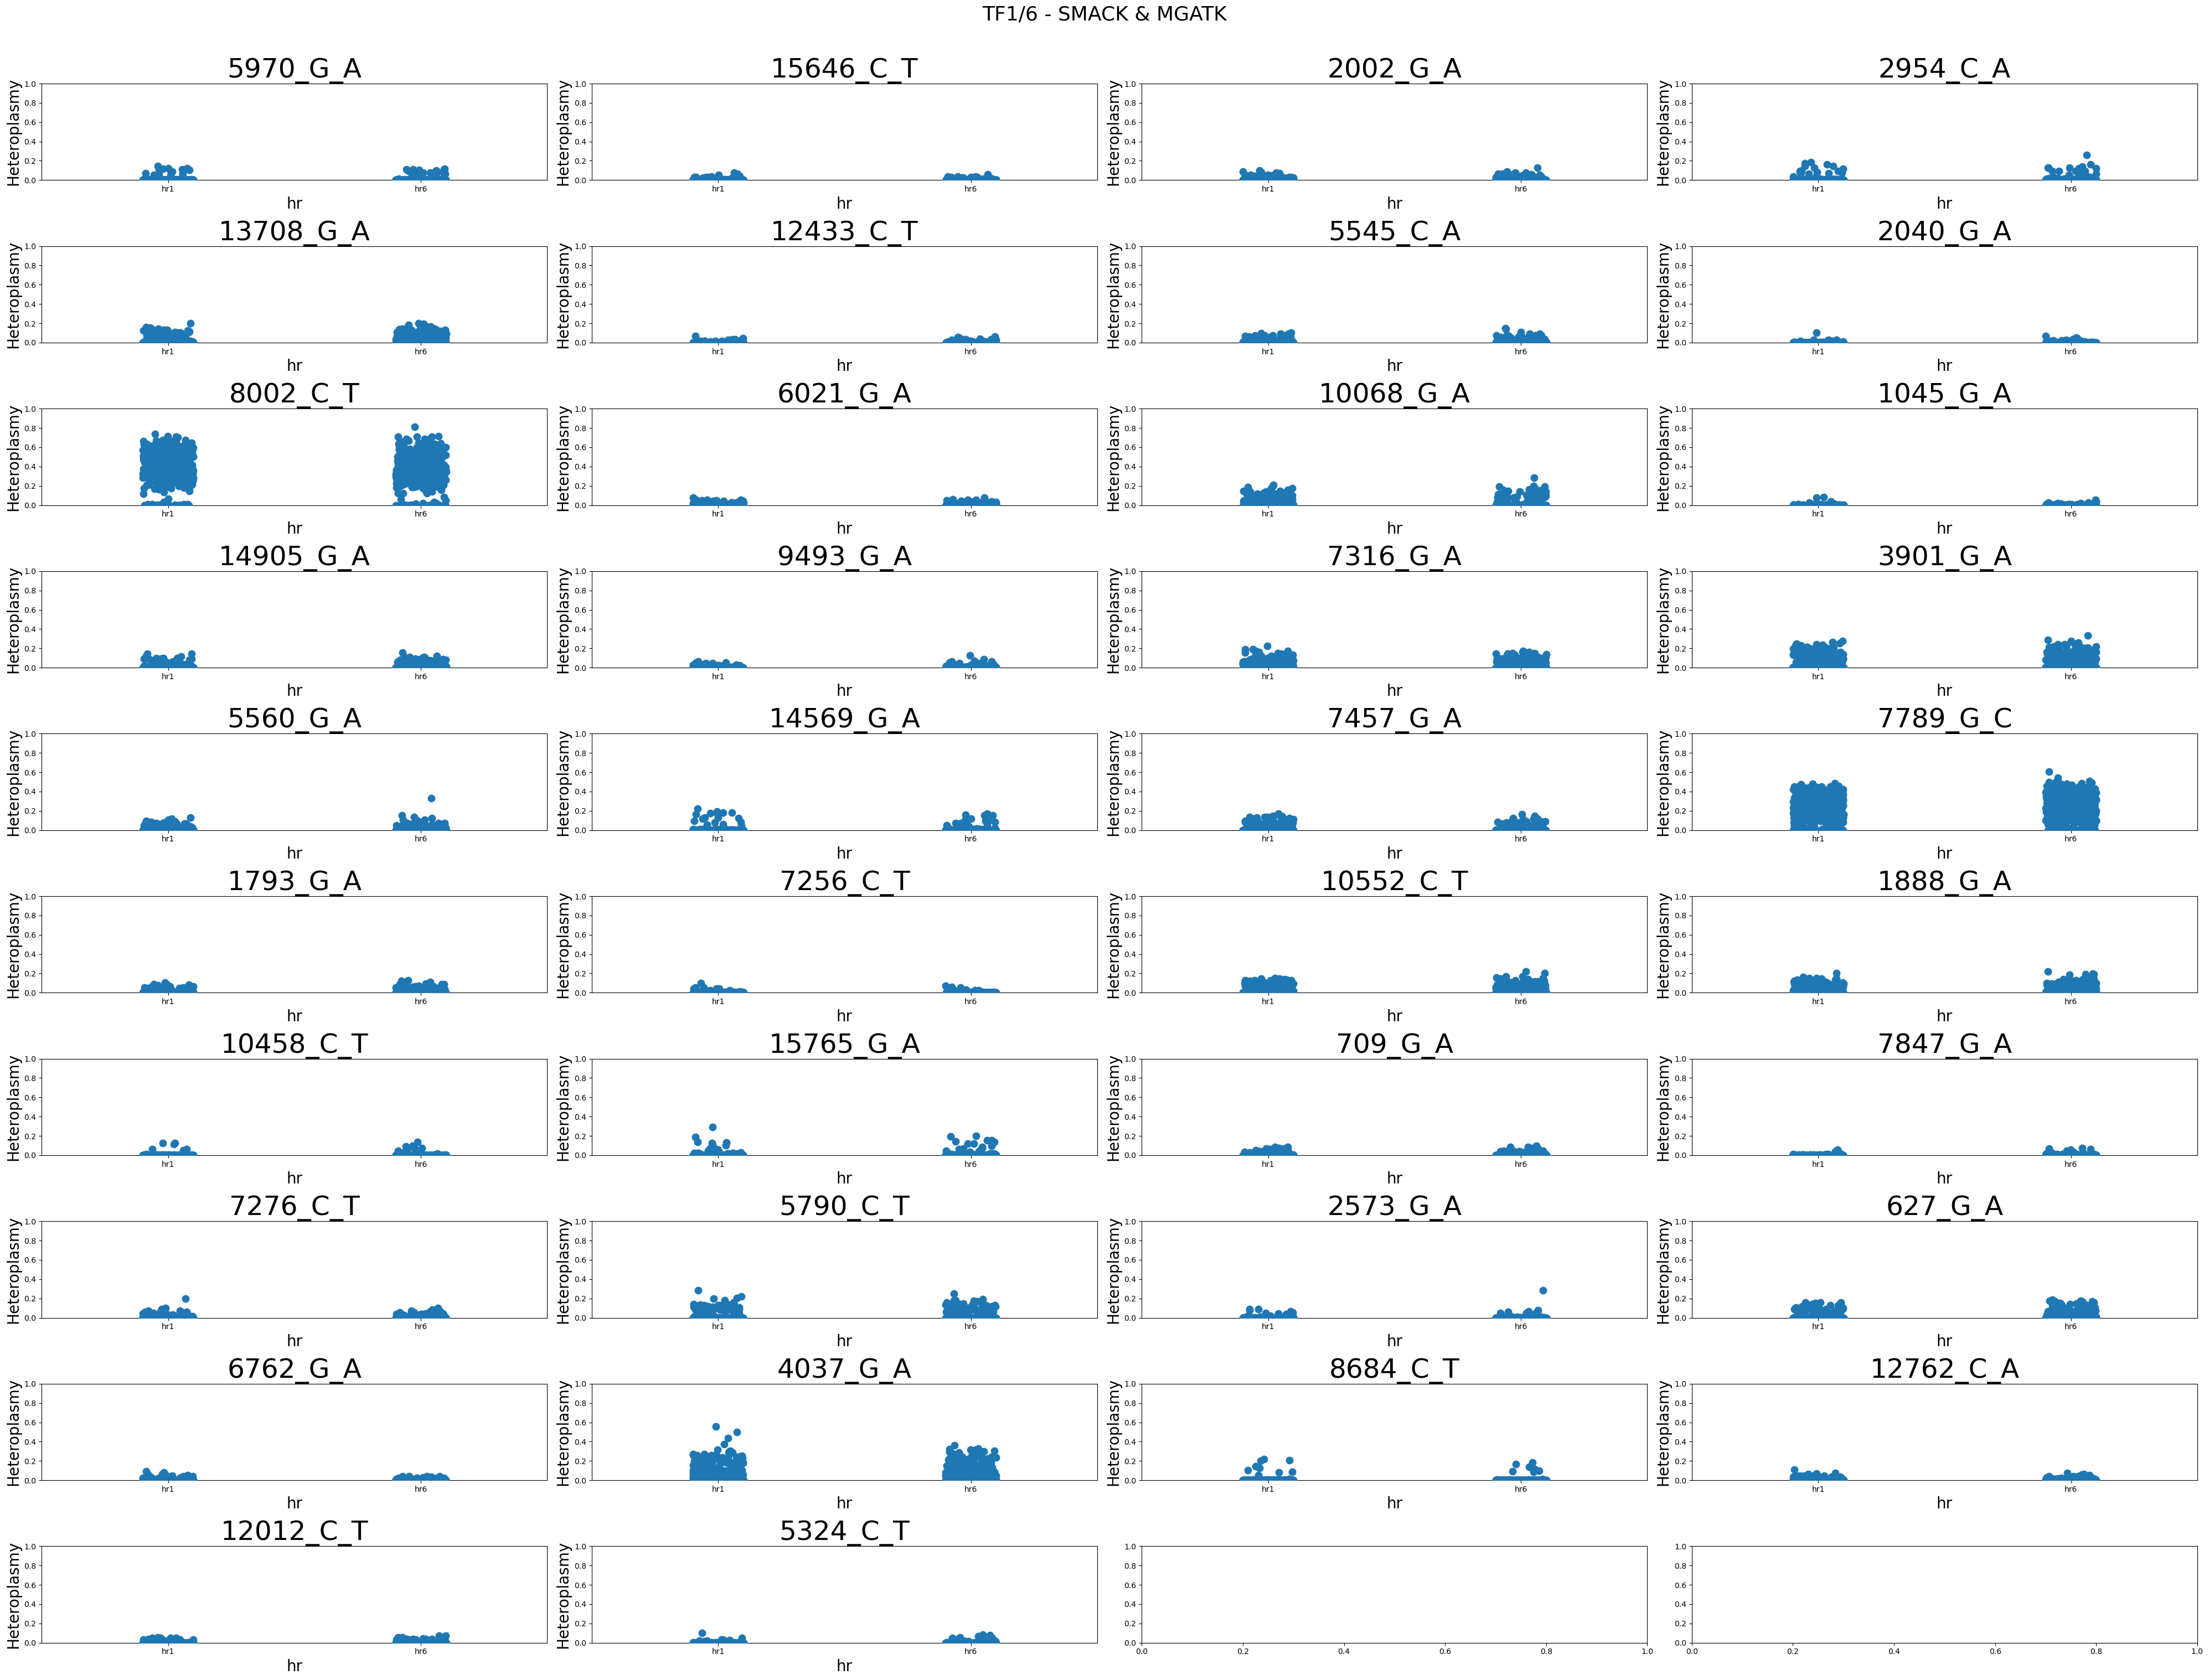

In [85]:
# SMACK and MGATK agree
melted = full_matrix.loc[list(center)].melt(value_name='heteroplasmy',id_vars='variant')
melted['hr'] = melted['variable'].apply(lambda v: v.split("_")[1])

fig,ax = plt.subplots(10,4,figsize=(40,30))
for i,variant in enumerate(list(center)):
    
    variant_df = melted[melted['variant']==variant]
    _ax = ax.reshape(-1)[i]
    
    _ax.set_title(variant,fontsize=35)
    sns.stripplot(variant_df, x='hr',y='heteroplasmy',ax=_ax,size=10)
    _ax.set_xlabel('hr',fontsize=20)
    _ax.set_ylabel('Heteroplasmy',fontsize=20)
    _ax.set_ylim([0,1])
#     _ax.set_xticklabels([])
    
fig.suptitle('TF1/6 - SMACK & MGATK',fontsize=26,y=1.01)
fig.tight_layout()